In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [43]:
"""Load Graph"""
G = nx.read_edgelist("./Data/higgs-social_network.edgelist", create_using=nx.DiGraph())
G = nx.convert_node_labels_to_integers(G)

print("Graph loaded:")

Graph loaded:


In [3]:
"""Load Subgraph"""
G = nx.read_edgelist("./Data/subgraph_1000.edgelist", create_using=nx.DiGraph())
G = nx.convert_node_labels_to_integers(G)

print("Subgraph loaded:")

Subgraph loaded:


In [32]:
del G

In [44]:
"""Subsample graph using Random Walks with teleporting"""
import random
import numpy as np

epsilon = 0.1
N = 1000
visited = set()
n = len(G)

seed = np.random.choice(n)

while len(visited) < N:
    if len(visited) == 0:
        node = seed
    else:
        jump = np.random.uniform()
        if jump < epsilon:
            #teleport
            node = np.random.choice(n)
        else:
            if len(G[node]) == 0:
                continue
            node = np.random.choice([u for u in G[node]])
        
    visited.add(node)

#H = G.subgraph(visited)
H = nx.subgraph(G, visited)
nx.write_edgelist(H, "./Data/subgraph_"+str(N)+".edgelist")
print(len(H))
del H

1000


In [4]:
"""Test Graph"""
print(len(G))
print(len(G.edges))

#for edge in G.edges():
#    G.edges[edge[0], edge[1]]['weight'] = 0.5
    
    
#G.nodes[1]['active'] = True

993
13022


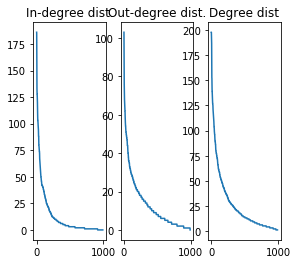

In [26]:
import networkx.algorithms.cluster as cluster

"""Plot sumary stats: Degree Distributions"""
in_degree = sorted([d for (n, d) in G.in_degree()], reverse=True)
out_degree = sorted([d for (n, d) in G.out_degree()], reverse=True)
degree = sorted([d for (n, d) in G.degree()], reverse=True)

plt.subplot(1, 4, 1)
plt.plot(range(len(G)), in_degree)
plt.title("In-degree dist.")

plt.subplot(1, 4, 2)
plt.plot(range(len(G)), out_degree)
plt.title("Out-degree dist.")

plt.subplot(1, 4, 3)
plt.plot(range(len(G)), degree)
plt.title("Degree dist")




plt.show()

In [13]:
"""
Read activity log into a list of actions
"""

retweet = "RT"
mention = "MT"
reply = "RE"

class Action:
    def __init__(self, u1, u2, t, kind):
        self.u1 = u1
        self.u2 = u2
        self.t = t
        self.kind = kind

action_log = []

with open("./Data/higgs-activity_time.txt", "r") as log:
    for line in log:
        words = line.split(" ")
        u1 = int(words[0])
        u2 = int(words[1])
        if (u1 in G and u2 in G):
            t = int(words[2])
            kind = words[3]
            action = Action(u1, u2, t, kind)
            action_log.append(action)

print(len(action_log))
# 563069 action items


718


In [27]:
"""
Compute crude Bernoulli-estimates of influence probs. 
"""

n = len(G)

activities_between_friends = 0
activities_between_strangers = 0

for action in action_log:
    if (G.has_edge(action.u1, action.u2) or G.has_edge(action.u2, action.u1)):
        activities_between_friends += 1
    else:
        activities_between_strangers += 1
        
print(activities_between_friends)
print(activities_between_strangers)


27
691


In [15]:
"""
Partition the graph into communities, save a community for further work
"""
import networkx.algorithms.community as community

communities = community.girvan_newman(G)

comm = next(communities)

while True:
    
    comm = next(communities)
    
    comm_sizes = [len(c) for c in comm]
    
    if max(comm_sizes) < 500:
        print("Found a partition of comminities with max-size 500")
        break;
    print("Found nothing, moving on")
    

Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on
Found nothing, moving on


KeyboardInterrupt: 